# ⚡ Machine Learning Project: Electricity Price Explanation ⚙️📉

**LANOTTE-MORO Alix, CHANDECLERC Antoine, GILLES Julien, FLEURY Nathan**  
**November 14, 2024**

## Project Overview

This project focuses on analyzing daily variations in electricity futures prices within the European market, specifically for France and Germany. Given the complex interplay of meteorological, energy production, and geopolitical factors impacting price fluctuations, the objective is to build a model that explains these movements rather than predicting exact prices. Leveraging Spearman correlation as the primary evaluation metric, we will employ a range of models—from linear regression benchmarks to advanced machine learning approaches (e.g., Random Forests, XGBoost, and RNNs)—to capture both linear and non-linear influences on price variations. This model aims to support energy producers, traders, and policymakers by providing insights to optimize trading strategies, manage risks, and strengthen the resilience of the European energy grid.

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.stats import spearmanr

import warnings 
warnings.filterwarnings("ignore")

## Data Importation and first preview

In [8]:
X_df =pd.read_csv('X_train_NHkHMNU.csv', delimiter= ',')
y_df =pd.read_csv('y_train_ZAN5mwg.csv', delimiter= ',')
X_test_df =pd.read_csv('X_test_final.csv', delimiter= ',')

df = pd.merge(X_df,y_df,on='ID')

print(df.shape)
df.head(10)

(1494, 36)


,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,TARGET
0,1054,206,FR,0.210099,-0.427458,-0.606523,0.606523,NaN,0.692860,NaN,...,-0.172680,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445,0.028313
1,2049,501,FR,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,...,-1.240300,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365,-0.112516
2,1924,687,FR,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,...,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952,-0.180840
3,297,720,DE,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,...,-1.114838,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948,-0.260356
4,1101,818,FR,0.143807,-0.617038,-0.924990,0.924990,NaN,0.990324,NaN,...,-0.541465,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378,-0.071733
5,1520,467,FR,-0.295296,-0.765120,-0.717490,0.717490,-1.117139,-0.200305,1.117139,...,-0.962519,-0.193837,-0.871600,-0.917234,0.102046,0.472708,0.891049,0.861408,1.124457,0.932105
6,1546,144,FR,-0.234965,-0.677085,0.399588,-0.399588,0.183998,-0.986235,-0.183998,...,-1.658394,-0.529800,-0.318920,-1.220760,-0.512991,0.147507,1.889739,0.498226,0.681739,0.192680
7,1069,1136,FR,0.332223,-0.546797,-0.507773,0.507773,NaN,0.569585,NaN,...,-0.744328,-0.051535,-0.701035,-0.394857,1.990978,0.902719,0.206769,0.993304,-0.223739,0.112850
8,1323,83,FR,-0.023023,-0.604694,-1.196787,1.196787,-0.519339,0.373109,0.519339,...,-0.207390,0.009356,-0.261496,-0.841560,-1.024980,-1.564174,2.688208,3.061210,3.755240,0.076153
9,1618,307,FR,0.564657,0.273776,-0.439063,0.439063,-0.636654,0.342057,0.636654,...,-0.972344,-0.806435,-0.752273,-0.767578,-0.371475,-0.459768,-1.487154,-0.692378,-0.768283,0.000000


### Pourcentage of missing values by columns

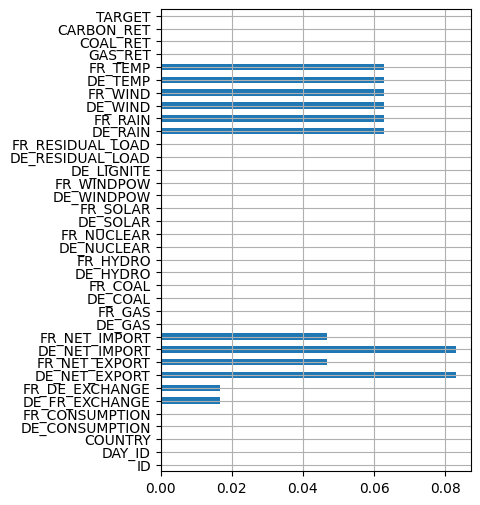

In [9]:
nb_missing = df.isna().sum()
rate_missing = nb_missing / df.ID.nunique()
fig, ax = plt.subplots(figsize=(4,6))
ax1 = ax
rate_missing.plot(kind="barh", ax=ax1)
ax1.grid()

We notice that there are a certain number of missing values, particularly for DE_NET_IMPORT and DE_NET_EXPORT, where the rate exceeds 8%. These data will need to be handled. Several options are available to us: filling them with the mean, replacing them with zeros, etc.

We chose to fill the missing values in each column with the respective column mean. Since the dataset is relatively small (around 1500 rows), dropping rows with missing values would significantly reduce the available data. By imputing missing values with the mean, we retain as many rows as possible, ensuring that the dataset remains comprehensive.

In [10]:
columns_to_fill = [
    "DE_FR_EXCHANGE", "FR_DE_EXCHANGE", "DE_NET_EXPORT", "FR_NET_EXPORT", 
    "DE_NET_IMPORT", "FR_NET_IMPORT", "DE_RAIN", "FR_RAIN", 
    "DE_WIND", "FR_WIND", "DE_TEMP", "FR_TEMP"
]
df_general = df

for column in columns_to_fill:
    if column in df_general.columns:
        df_general[column].fillna(df_general[column].mean(), inplace=True)

### Plot of the distribution of each columns of the data

Text(0.5, 1.0, 'TARGET')

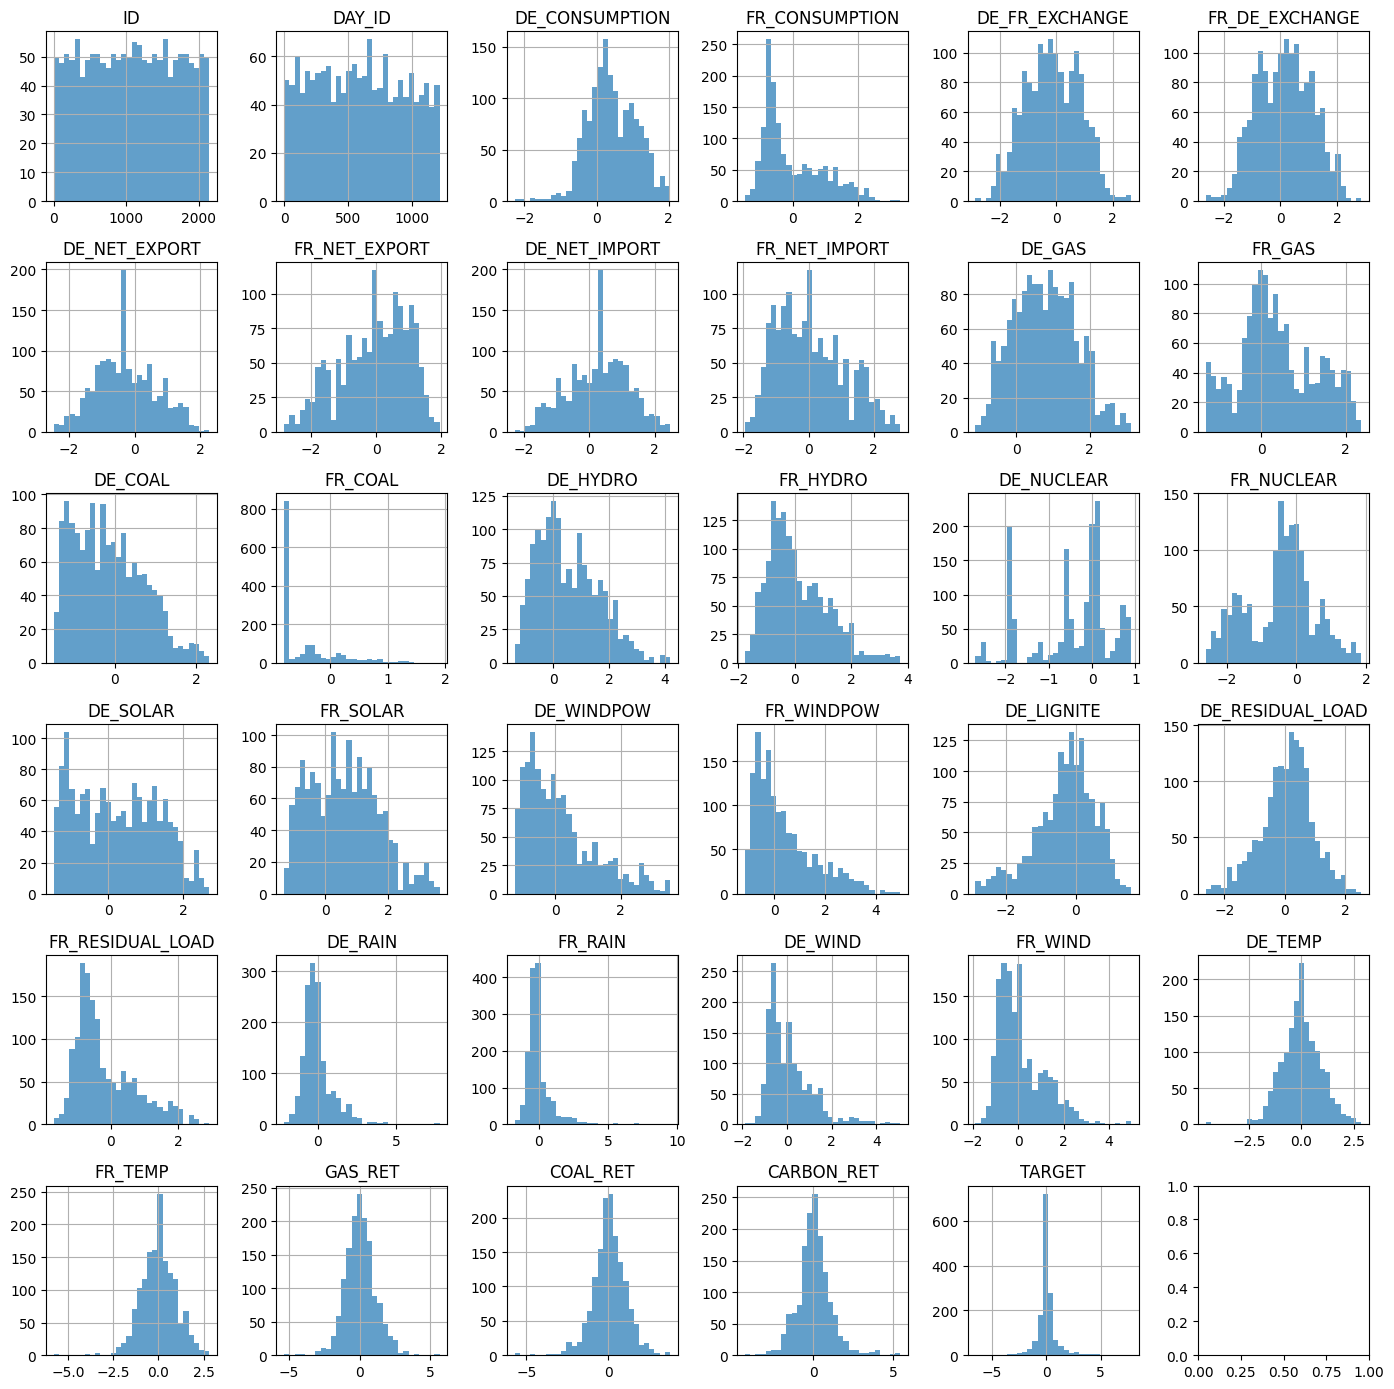

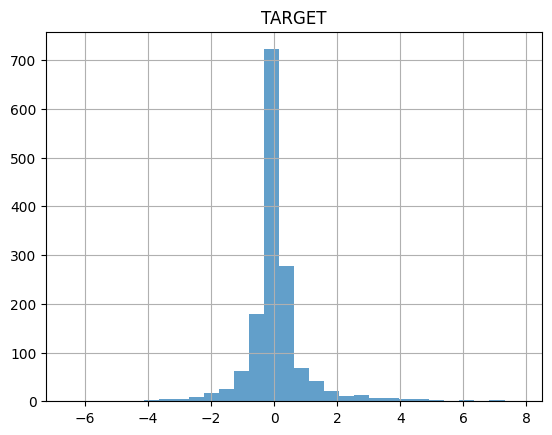

In [15]:
features = [feature for feature in df.columns if feature != "COUNTRY"]

nb_col = 6
nb_row = - (-len(features)//6)
fig, ax = plt.subplots(nb_row, nb_col, figsize=(14,14))

for i, feature in enumerate(features):
    i_col = i % nb_col
    i_row = i // nb_col
    ax1 = ax[i_row, i_col]
    
    ax1.set_title(feature)
    ax1.grid()
    df[feature].hist(bins= 30, ax=ax1, alpha=0.7)

plt.tight_layout()

fig, ax = plt.subplots()
ax1 = ax
y_df["TARGET"].hist(bins= 30, ax=ax1, alpha=0.7)
ax1.set_title("TARGET")

In [16]:
print("Nb of data points by country:")
print(df.COUNTRY.value_counts())

Nb of data points by country:
COUNTRY
FR    851
DE    643
Name: count, dtype: int64


We aim to predict prices for France and Germany. To better understand the factors influencing price in each country, we will plot the data separately. This allows us to evaluate whether the factors driving price variations are consistent or differ between the two countries.

In [18]:
df_de = df[df['COUNTRY'] == 'DE']
df_de = df_de.drop(columns=['COUNTRY'])
df_de.fillna(df_de.mean(), inplace=True)

df_fr = df[df.COUNTRY == "FR"]
df_fr = df_fr.drop(columns=['COUNTRY'])
df_fr.fillna(df_fr.mean(), inplace=True)

### Plot of the distribution of each column by country

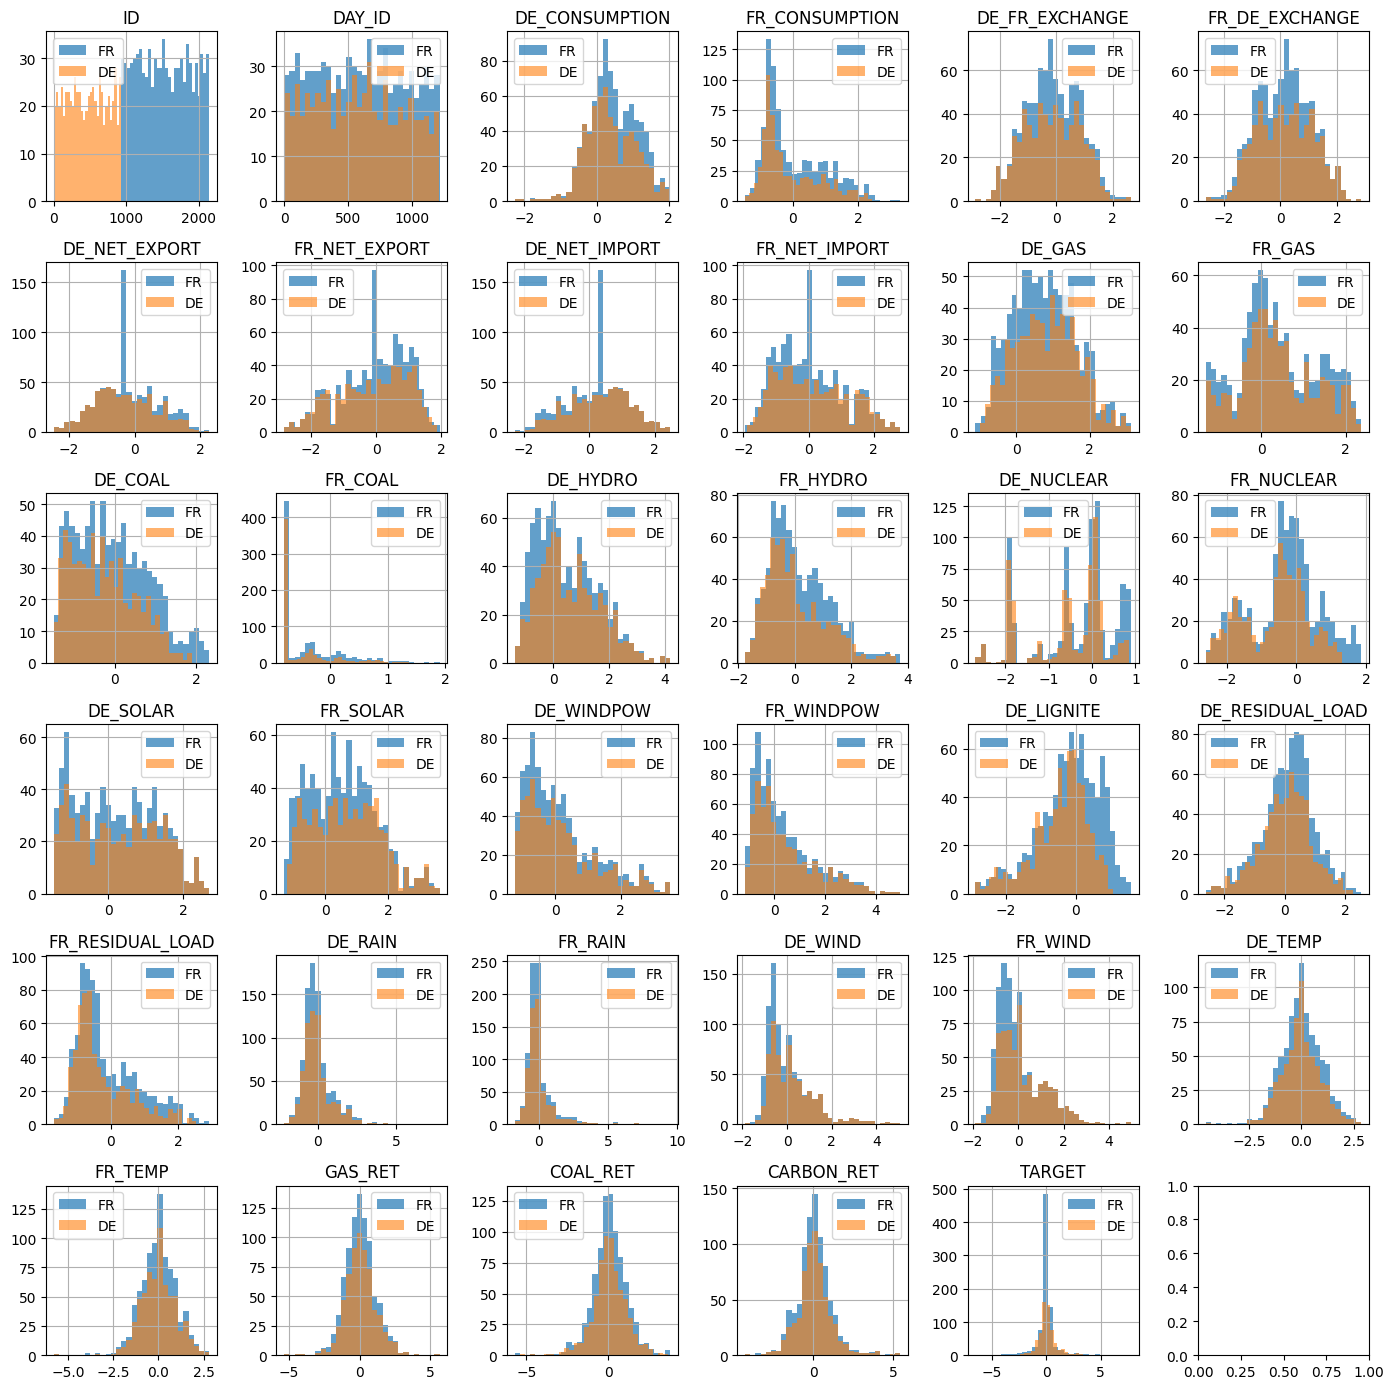

In [21]:
nb_col = 6
nb_row = - (-len(features)//6)
fig, ax = plt.subplots(nb_row, nb_col, figsize=(14,14))

for i, feature in enumerate(features):
    i_col = i % nb_col
    i_row = i // nb_col
    ax1 = ax[i_row, i_col]
    
    ax1.set_title(feature)
    ax1.grid()
    df_fr[feature].hist(bins= 30, ax=ax1, alpha=0.7, label= "FR")
    df_de[feature].hist(bins= 30, ax=ax1, alpha=0.6, label= "DE")
    ax1.legend()

plt.tight_layout()

We observe that the **distributions of various features** are generally similar between **France** and **Germany**. However, it is notable that the data associated with **Germany** exhibit greater **variability** across several variables. This can be attributed to a more **comprehensive** and **dense database** on the French side.  

It could be relevant to separate the data into **two distinct sets** to develop **specific models** for each country. Indeed, the **economic differences** between France and Germany are significant and can influence their respective behaviors, particularly regarding **electricity prices**. These differences are attributable to several factors, including:  

- **The structure of the energy mix**: France relies heavily on **nuclear energy**, whereas Germany has gradually reduced its use of nuclear energy in favor of **renewable sources** such as wind and solar. This creates differing dynamics in electricity supply and **sensitivity to weather conditions**.  

- **Energy policies**: The energy strategies differ between the two countries, with a faster energy transition in **Germany**, accompanied by **subsidy and regulatory policies** to promote renewables. In France, dependence on nuclear energy leads to a policy focus on **supply stability**.  

- **Climatic and geographical conditions**: Climatic variations, such as differences in **temperature** and **precipitation**, differently affect energy consumption in each country. For instance, France may experience higher heating demand in winter, while Germany, with its significant **wind power infrastructure**, is more impacted by wind variations.  

These differences suggest that a single model might not adequately capture the unique dynamics of each country. Therefore, an approach using **separate models** for **France** and **Germany** could better reflect their economic and energy-specific characteristics.


### Analysis of Data Availability 

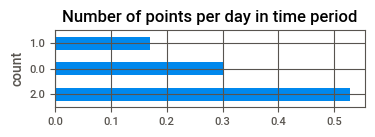

In [138]:
F = df.DAY_ID.value_counts().sort_index()
F = F.reindex(range(F.index.max()))
F = F.fillna(0)
F = F.value_counts()
F /= F.sum()
fig, ax = plt.subplots(figsize=(4,1))
ax1 = ax
ax1.set_title("Number of points per day in time period")
F.plot(kind="barh", ax=ax1)
ax1.grid()

The distribution of days based on data availability (53% of days with data for both countries, 30% without data, and the remainder with partial data available for only one of the two countries) provides important insights into the quality and representativeness of the sample used in our analysis.  

This distribution highlights the need to adopt strategies for handling missing data. Two approaches can be considered:  

- **Separate models by country** for days where data is available for only one country.  
- **Imputation or exclusion of days without data**, depending on their proportion and the potential impact on the analysis.  

These observations call for caution when interpreting the results, as irregular data availability may affect conclusions regarding temporal phenomena or direct comparisons between France and Germany.



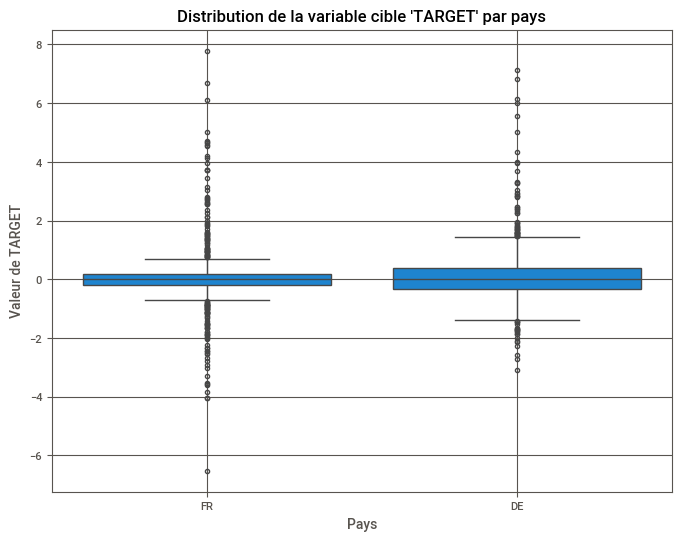

In [139]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="COUNTRY", y="TARGET", data=df)
plt.title("Distribution de la variable cible 'TARGET' par pays")
plt.xlabel("Pays")
plt.ylabel("Valeur de TARGET")
plt.grid(True)
plt.show()

Examining the distribution of the target variable for both countries reveals that the median is similar and close to zero for both France and Germany. This suggests that the target values are well **centered around zero** in both cases, indicating a generally balanced distribution of positive and negative values. This centrality can be interpreted as follows:  

- **Absence of trend bias**: The proximity of the median to zero for both countries suggests there is no systematic bias in the target values. In other words, the values do not skew significantly toward positive or negative levels, which is favorable for comparative analyses or symmetric predictive models.  
- **Quantile**: The interquartile range is slightly narrower for France, meaning that most TARGET values are more concentrated around the median compared to Germany. However, the presence of numerous outliers in Francesignificantly extends the range of extreme values, potentially requiring special handling to prevent undue influence on the models.  

#### Presence of Outliers  

Another striking aspect is the presence of **numerous outliers in the French data**, whereas extreme values are less frequent in Germany. This could reflect several dynamics:  

- **Increased variability in French data**: The higher frequency of extreme values in France might indicate greater volatility in the market or factors influencing the target variable.  
- **Influence of country-specific conditions**: France and Germany differ in infrastructure and energy mix (e.g., France's heavier reliance on nuclear energy compared to Germany). These structural differences could lead to extreme variations in certain energy indicators, especially during crises or periods of exceptional demand.  
- **Potential impact on predictive models**: These outliers could complicate modeling for the French data. Extreme values might influence the mean and variance, which could affect models sensitive to significant deviations. Techniques for managing outliers (e.g., data transformation or smoothing extreme values) may be necessary to enhance model robustness.  

#### Implications for Analysis  

The observations regarding centrality and outliers have several implications for analysis and modeling:  

1. **Strategies for managing extreme values**: The outliers in the French data may require special handling, such as outlier removal or the application of normalization or logarithmic transformation techniques to reduce their impact.  
2. **Country-specific approaches**: Since the target variable's distribution differs between France and Germany (particularly regarding outliers), it may be advisable to build separate models or apply differentiated preprocessing for each country.  
3. **Use of robust models**: In the presence of numerous outliers, more robust models, such as those based on the median (quantile regression) or ensemble algorithms (e.g., random forest or gradient boosting), might be better suited than standard linear models.  

#### Summary  

Although the French and German distributions of the target variable exhibit similar centrality, the higher frequency of outliers in France calls for a cautious approach. Proper handling of these outliers is essential to ensure the quality of results and the robustness of predictive models.


### Pearson's Correlation Matrix

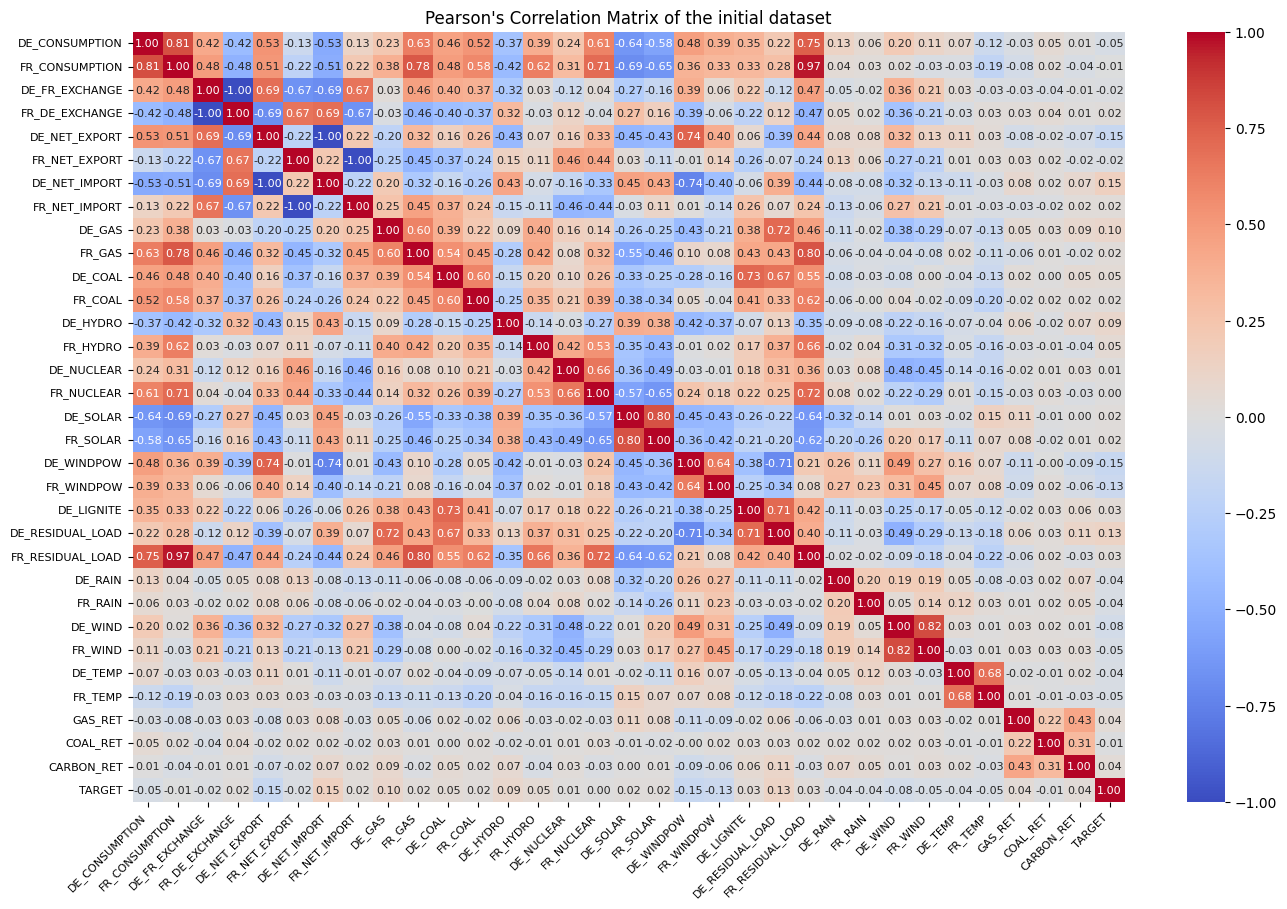

In [23]:
plt.figure(figsize=(16, 10))
df_cleaned = df_general.drop(columns=['ID', 'DAY_ID','COUNTRY'])
pearson_corr = df_cleaned.corr(method='pearson')
sns.heatmap(pearson_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, annot_kws={"size": 8})
plt.title("Pearson's Correlation Matrix of the initial dataset")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.show()


### Spearman's Correlation Matrix

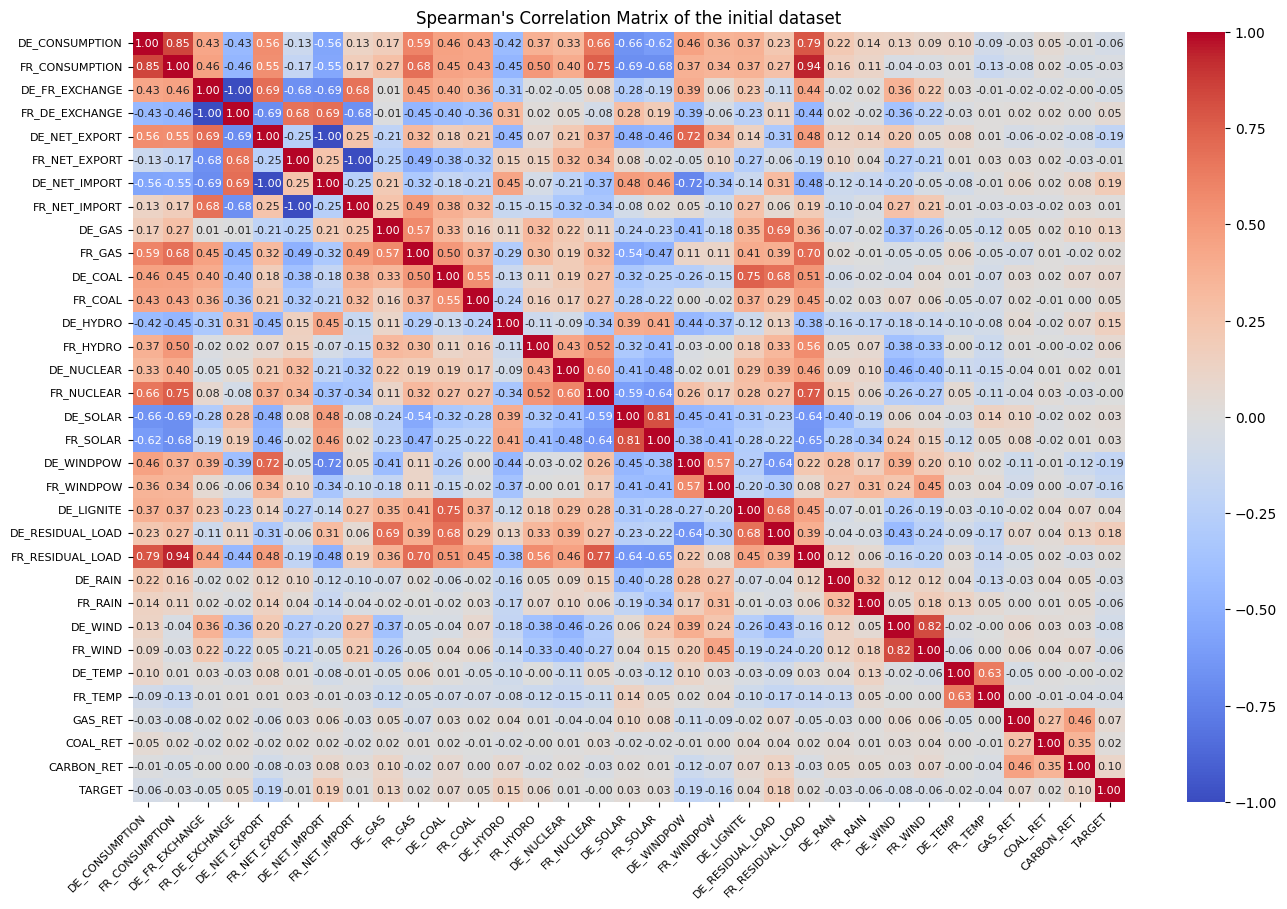

In [26]:
plt.figure(figsize=(16, 10))
df_cleaned = df.drop(columns=['ID', 'DAY_ID','COUNTRY'])
spearman_corr = df_cleaned.corr(method='spearman')
sns.heatmap(spearman_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, annot_kws={"size": 8})
plt.title("Spearman's Correlation Matrix of the initial dataset")   
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.show()

By examining the **correlation matrices**, it is noticeable that the **Spearman** matrix shows stronger correlations with the '**TARGET**' row compared to the **Pearson** matrix. This difference arises because **Spearman** evaluates the **monotonic relationship** between variables, whether linear or not, based on their **ranks** rather than their absolute values. This method better captures relationships when the data is **nonlinear** or contains **outliers**, which might distort the **Pearson** correlation.


### Energy Production Distribution by Country

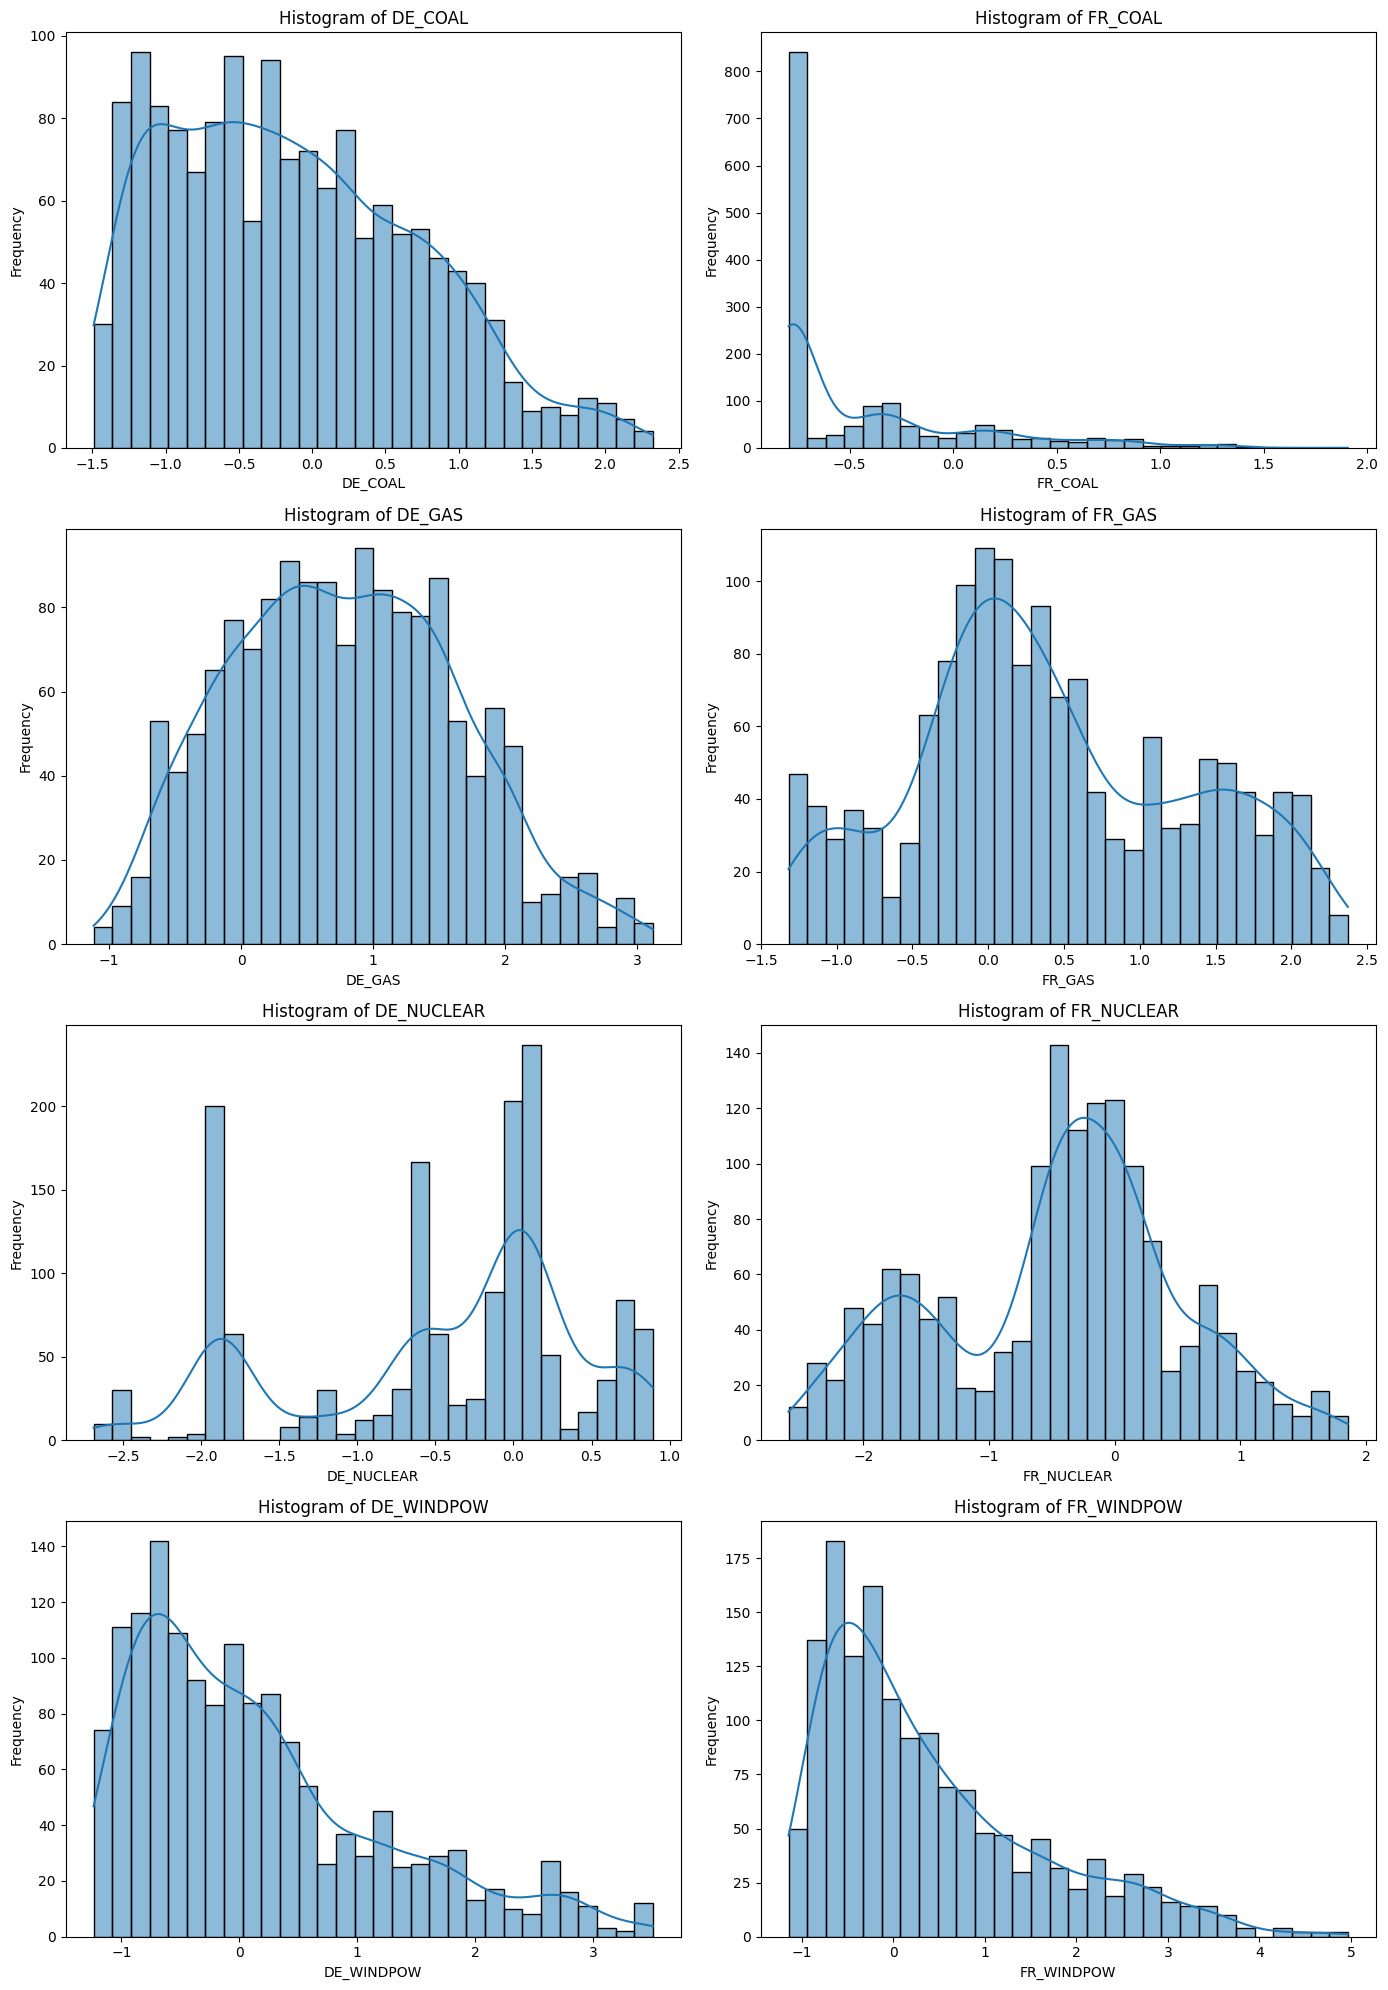

In [27]:
energy_sources = ['DE_COAL', 'FR_COAL', 'DE_GAS', 'FR_GAS', 'DE_NUCLEAR', 'FR_NUCLEAR', 'DE_WINDPOW', 'FR_WINDPOW']

n_rows = len(energy_sources) // 2

plt.figure(figsize=(14, n_rows * 5))

for i, source in enumerate(energy_sources, 1):
    plt.subplot(n_rows, 2, i)
    sns.histplot(df_general[source], bins=30, kde=True)
    plt.title(f'Histogram of {source}')
    plt.xlabel(source)
    plt.ylabel('Frequency')
    
plt.tight_layout()
plt.show()

These charts demonstrate that while certain energy sources, such as **wind power**, appear to be similarly distributed between **France** and **Germany**, the two countries clearly adopt **distinct energy strategies**. Notably, **France** stands out for its greater **stability** in **nuclear energy** production, while it remains relatively **weak** in terms of **coal** production.


### Spearman's Correlation Matrix for Data Related to France  

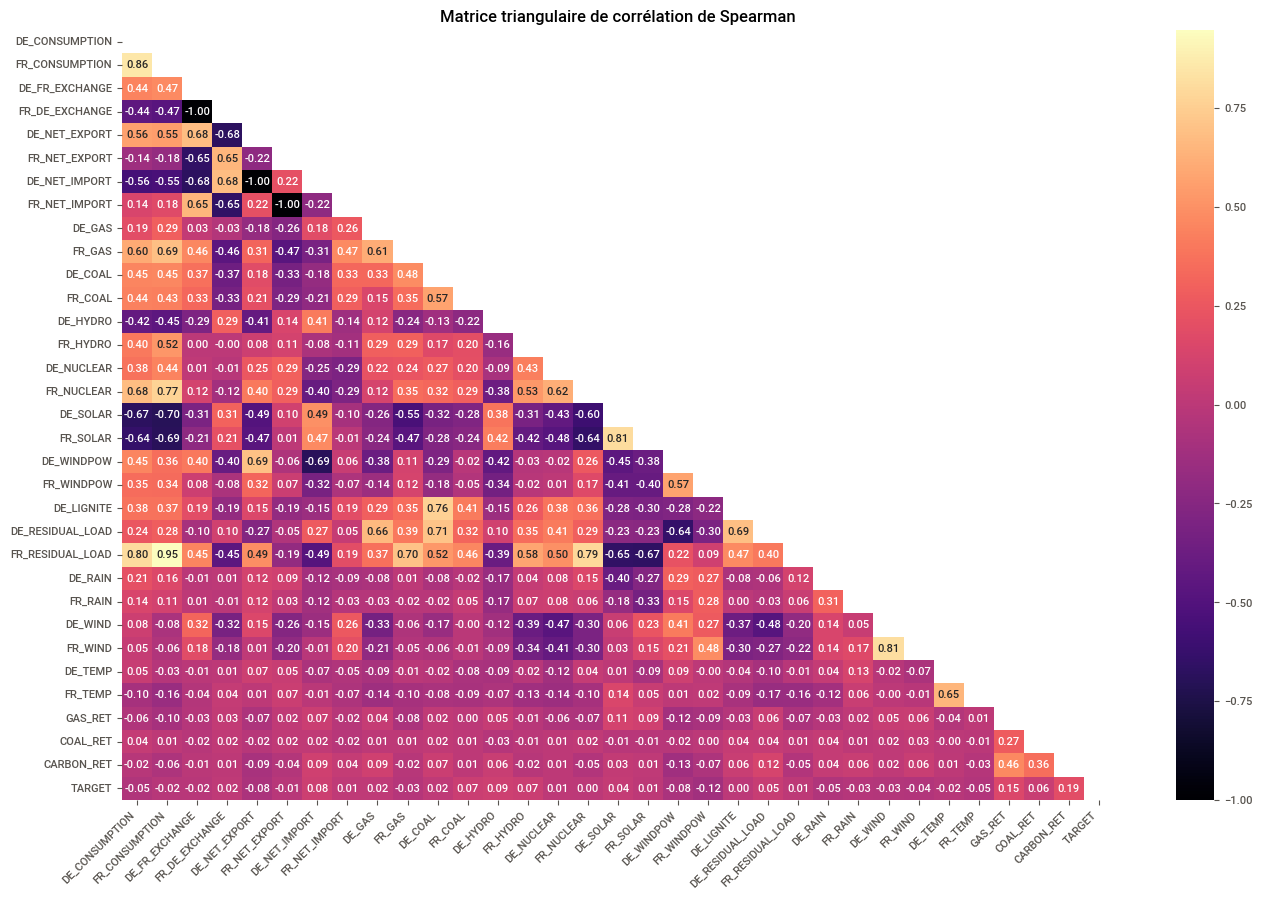

In [143]:
df_fr_cleaned=df_fr.drop(['ID','DAY_ID'],axis=1)
corr_matrix = df_fr_cleaned.corr()
plt.figure(figsize=(16, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
spearman_corr = df_fr_cleaned.corr(method='spearman')
sns.heatmap(spearman_corr, annot=True,mask=mask, fmt=".2f", cmap="magma", cbar=True, annot_kws={"size": 8})
plt.title("Matrice triangulaire de corrélation de Spearman")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.show()

### Spearman Correlation Matrix for Data Related to Germany 

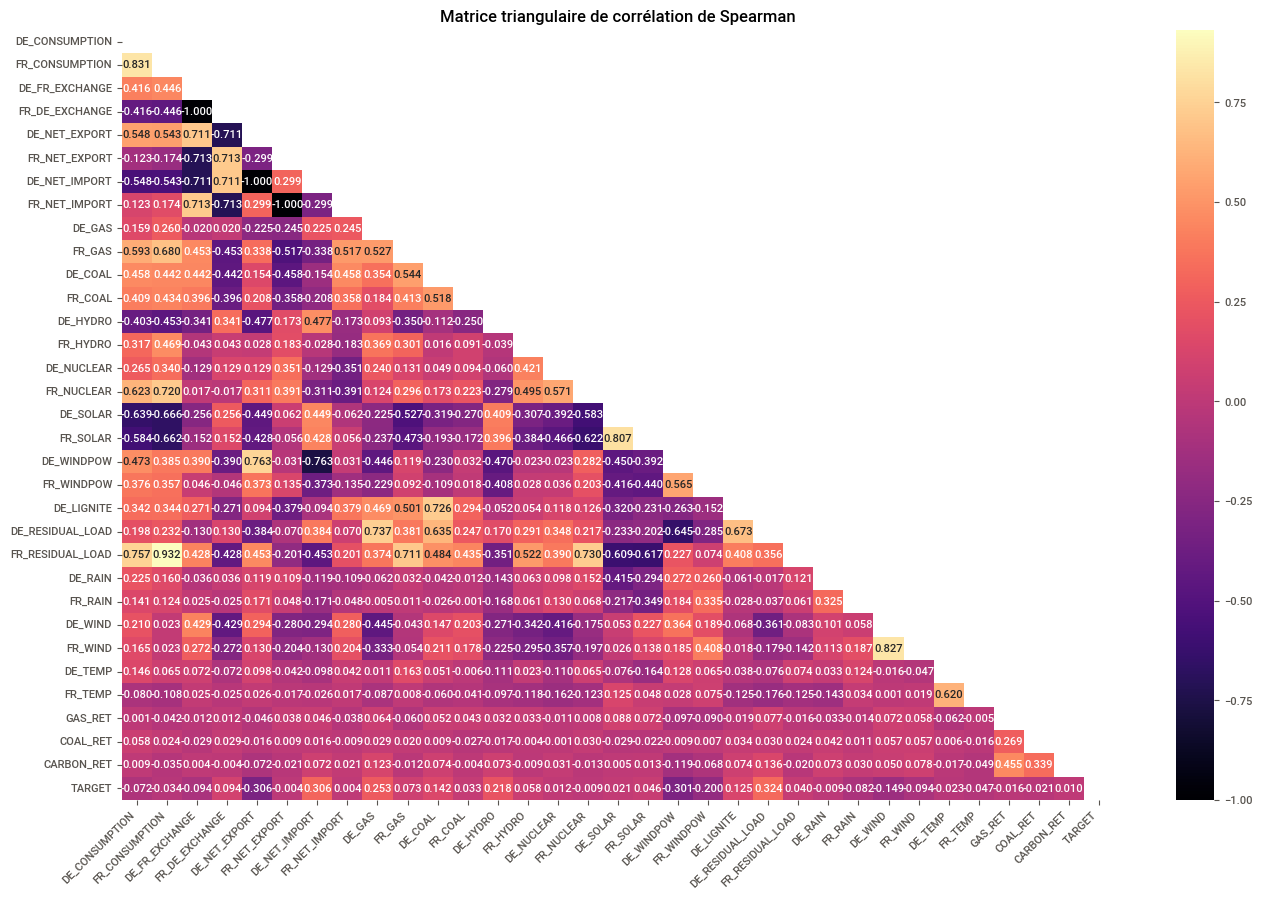

In [144]:
df_de_cleaned=df_de.drop(['ID','DAY_ID'],axis=1)
corr_matrix = df_de_cleaned.corr()
plt.figure(figsize=(16, 10))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

spearman_corr = df_de_cleaned.corr(method='spearman')
sns.heatmap(spearman_corr,mask=mask, annot=True, fmt=".3f", cmap="magma", cbar=True, annot_kws={"size": 8})
plt.title("Matrice triangulaire de corrélation de Spearman")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [145]:
df.fillna(df.drop(columns="COUNTRY").mean(), inplace=True)

In [146]:
# Remplacer les valeurs manquantes (None ou NaN) par la moyenne du pays
for country in df["COUNTRY"].unique():
    country_avg = df[df["COUNTRY"] == country].drop(columns="COUNTRY").mean()  # Calcule la moyenne des colonnes pour le pays
    df.loc[df["COUNTRY"] == country] = df.loc[df["COUNTRY"] == country].fillna(country_avg)  # Remplacer les NaN par la moyenne


In [147]:
df['DE_NET_EXPORT'].mean()

-0.25633175944483827

## Model Evaluation

### Spearman's Correlation in Our Project

In this project, we aim to explain daily variations in electricity futures prices in Europe. Given the complex and non-linear relationships between factors like energy production, weather conditions, and market prices, **Spearman's correlation** is a suitable tool to evaluate our model's performance, alongside other metrics like R², MAE, and MSE.

### Why Use Spearman?

1. **Monotonicity**: The relationships between variables, such as the impact of gas prices on electricity prices, may be monotonic but non-linear. Spearman captures these monotonic trends where Pearson would fail.

2. **Robustness to Outliers**: Since the data can contain extreme values (e.g., sudden price spikes), Spearman is less sensitive to outliers, providing a more stable evaluation.

3. **Capturing Non-linear Relationships**: Variables like renewable energy production or electricity exchanges may have a non-linear effect. Spearman helps measure the monotonic relationship, even if it's not strictly linear.

### Spearman's Rank Correlation Formula

The Spearman rank correlation coefficient ($\rho$) is calculated as:

$$
\rho = 1 - \frac{6 \sum d_i^2}{n(n^2 - 1)}
$$

Where:
- $d_i$ is the difference between the ranks of corresponding values in the two datasets.
- $n$ is the total number of data pairs.

### Additional Evaluation Metrics

- **R²**: This metric tells us the proportion of the variance in the target variable (electricity prices) explained by the model. A higher R² indicates a better fit.
  
- **MAE (Mean Absolute Error)**: This measures the average magnitude of errors in predictions, providing insight into how close the model's predictions are to the actual values, with smaller values being preferable.
  
- **MSE (Mean Squared Error)**: This gives us the squared average of the model's prediction errors, emphasizing larger errors more heavily. Like MAE, smaller values indicate better model performance.

Spearman's correlation is ideal for our project because it allows us to evaluate complex, non-linear trends in electricity prices while being robust to outliers. Alongside Spearman, we also use R², MAE, and MSE to provide a comprehensive view of our model's performance and ensure it captures the underlying dynamics of the electricity market effectively.


### K-Fold Cross-Validation and Model Evaluation

We use **k-fold cross-validation** to assess model performance on multiple data splits. The procedure involves:

1. **Data Preparation**: Features (`X`) and target (`y`) are separated from the dataset.
2. **K-Fold Cross-Validation**: Data is split into `k` folds, with each fold used for testing once.
3. **Standardization**: Features are scaled to have zero mean and unit variance using **StandardScaler**.
4. **Model Training**: The model is trained on the training data and predictions are made on the test set.
5. **Evaluation Metrics**: We calculate **Spearman's correlation**, **R²**, **MAE**, and **MSE** to assess model accuracy.
6. **Result Aggregation**: Metrics from each fold are collected in a DataFrame and returned.

This method provides a robust evaluation of the model’s performance across different subsets of data.


In [50]:
from sklearn.model_selection import KFold
# Import timeseries split
from sklearn.model_selection import TimeSeriesSplit

def kfoldCrossValidation(df, M, k):
    X = df.drop(columns=['ID', 'TARGET'])
    y = df['TARGET']

    kfold = TimeSeriesSplit(n_splits=k)
    result = pd.DataFrame(columns=['Spearman', 'R2', 'MAE', 'MSE'])
  
    X = np.array(X)
    y = np.array(y)
  
    # Boucle de validation croisée
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X[train_index], X[test_index]     
        y_train, y_test = y[train_index], y[test_index]

        # Standardisation des données
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Entraînement et prédiction
        M.fit(X_train, y_train)
        y_pred_test = M.predict(X_test)
    
        # Calcul des métriques
        result_temp = pd.DataFrame([{
            'Spearman': spearmanr(y_test, y_pred_test).correlation, 
            'R2': M.score(X_test, y_test), 
            'MAE': np.mean(np.abs(y_test - y_pred_test)), 
            'MSE': np.mean((y_test - y_pred_test) ** 2)
        }])
    
        if not result_temp.isna().all().all():  
            result = pd.concat([result, result_temp], ignore_index=True)
    
    return result


## First Model Using Linear Regression

A faire

In [76]:
print(kfoldCrossValidation(df_fr, LinearRegression(), 5).mean())
print(kfoldCrossValidation(df_de, LinearRegression(), 5).mean())
print(kfoldCrossValidation(df_general.drop(columns=['COUNTRY']), LinearRegression(), 5).mean())

Spearman    0.019236
R2         -0.449306
MAE         0.743614
MSE         1.473277
dtype: float64
Spearman    0.270680
R2         -0.047974
MAE         0.663926
MSE         1.057455
dtype: float64
Spearman    0.178836
R2         -0.050411
MAE         0.608926
MSE         1.069935
dtype: float64


In [58]:
#Drop the columns starting with DE for df_fr and FR for df_de
df_fr = df_fr[df_fr.columns.drop(list(df_fr.filter(regex='DE')))]
df_fr.drop(columns=['FR_NET_EXPORT'], errors='ignore', inplace=True)
df_de = df_de[df_de.columns.drop(list(df_de.filter(regex='FR')))]
df_de.drop(columns=['DE_NET_EXPORT'], errors='ignore', inplace=True)

df_fr

,ID,DAY_ID,FR_CONSUMPTION,FR_NET_IMPORT,FR_GAS,FR_COAL,FR_HYDRO,FR_NUCLEAR,FR_SOLAR,FR_WINDPOW,FR_RESIDUAL_LOAD,FR_RAIN,FR_WIND,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,TARGET
0,1054,206,-0.427458,-0.692860,-0.213766,0.288782,0.207838,-0.190463,1.248911,-0.269460,-0.444661,-0.556356,-0.283160,-0.063404,0.339041,0.124552,-0.002445,0.028313
1,2049,501,-1.003452,1.130838,0.426940,-0.762153,-0.807112,-2.185961,3.237380,-0.107350,-1.183194,-0.770457,0.828412,1.831241,-0.659091,0.047114,-0.490365,-0.112516
2,1924,687,1.978665,1.682587,2.122241,0.777053,0.779142,0.735137,-0.371039,-0.141239,1.947273,-0.313338,0.487608,0.114836,0.535974,0.743338,0.204952,-0.180840
4,1101,818,-0.617038,-0.990324,-0.240862,-0.274975,-0.795983,0.176935,0.723587,-0.564498,-0.526267,-0.424550,-1.011560,0.729495,0.245109,1.526606,2.614378,-0.071733
5,1520,467,-0.765120,0.200305,0.306422,-0.775944,0.593251,-1.920695,2.054491,-0.245628,-0.860628,-0.193837,-0.917234,0.472708,0.891049,0.861408,1.124457,0.932105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1483,1776,510,-0.704613,-1.112333,-0.456156,-0.793961,0.538795,-0.539194,1.013134,0.149270,-0.795046,1.021354,0.805043,-0.555211,1.946355,0.867074,1.322433,0.108277
1486,1401,985,0.944372,-0.499653,1.320758,-0.779539,0.375729,0.791698,-1.054641,1.646472,0.634867,-0.441164,-0.658130,0.829517,0.494188,1.011794,1.472650,0.827636
1487,1728,905,0.459382,1.048997,0.715357,-0.305680,-0.188248,-0.457660,1.953376,0.536297,0.251190,-0.152293,1.697829,-2.069991,1.145686,0.335645,0.606318,0.049618
1490,1674,887,1.752840,0.152146,1.558300,0.230746,2.957114,0.926279,-0.923261,0.789618,1.666252,0.019357,0.123099,0.008404,0.932633,-0.085690,0.356356,-0.063546


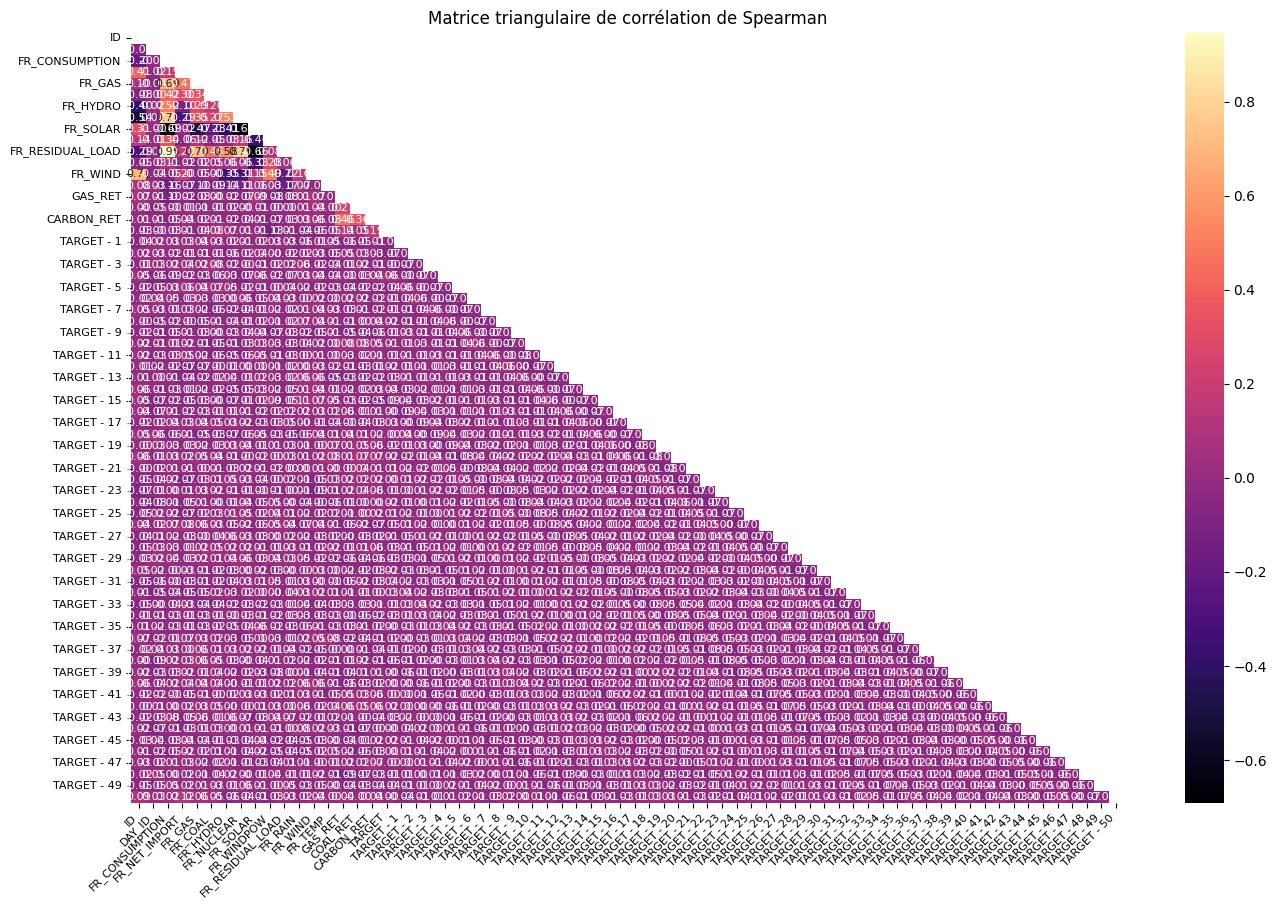

TARGET         1.000000
FR_HYDRO       0.079066
CARBON_RET     0.067389
TARGET - 45    0.059544
TARGET - 12    0.059315
TARGET - 48    0.056795
Name: TARGET, dtype: float64

In [78]:
df_fr.sort_values('DAY_ID')
for i in range(1, 20):
    df_fr[f'TARGET - {i}'] = df_fr['TARGET'].shift(i)

#COrrelation matrix de spearman
corr_matrix = df_fr.corr()
plt.figure(figsize=(16, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
spearman_corr = df_fr.corr(method='spearman')
sns.heatmap(spearman_corr, annot=True,mask=mask, fmt=".2f", cmap="magma", cbar=True, annot_kws={"size": 8})
plt.title("Matrice triangulaire de corrélation de Spearman")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.show()

#Affiche les 5 features avec la plus grande corrélation avec la variable cible
corr_matrix = df_fr.corr()
corr_matrix['TARGET'].sort_values(ascending=False).head(6)



In [75]:
df_fr.dropna(inplace=True)

## Feature engineering
We want to add more columns to create more precise models so we will do some feature engineering 

We can compute rolling statistics to capture trends and fluctuations over time. 
The rolling mean smooths the data to highlight long-term trends, while the rolling standard deviation measures volatility and variability within specific time windows (weekly and monthly). 
The slope, calculated using linear regression on rolling windows, captures the rate of change or trend direction, helping to identify whether values are generally increasing or decreasing over time.

In [211]:
# Function to calculate rolling statistics (mean, std, median, min, max, slope) for DE_ and FR_ columns
def add_statistics(df, variables, windows):
    def slope(y):
        return np.polyfit(range(len(y)), y, 1)[0] if len(y) > 0 else np.nan

    for var in variables:
        for window in windows:
            for country in ['DE_', 'FR_']:
                col = f'{country}{var}'
                df[f'{col}_MEAN_{window}D'] = df[col].rolling(window=window).mean()
                df[f'{col}_STD_{window}D'] = df[col].rolling(window=window).std()
                df[f'{col}_MEDIAN_{window}D'] = df[col].rolling(window=window).median()
                df[f'{col}_MIN_{window}D'] = df[col].rolling(window=window).min()
                df[f'{col}_MAX_{window}D'] = df[col].rolling(window=window).max()
                df[f'{col}_SLOPE_{window}D'] = df[col].rolling(window=window).apply(slope, raw=True)
    return df


Then we can use technical indicators widely use in finance like volatility and moving averages that are used to analyze time-series data. Volatility, typically measured by rolling standard deviation, helps quantify the level of fluctuation or uncertainty in the data. Moving averages, especially exponential moving averages (EMA), are used to smooth short-term fluctuations and highlight long-term trends or cycles, making it easier to detect underlying patterns in the data.

In [212]:
def add_indicators(df):
    for commodity in ['GAS_RET', 'COAL_RET', 'CARBON_RET']:
        df[f'{commodity}_VOLATILITY_WEEKLY'] = df[commodity].rolling(window=7).std()
        df[f'{commodity}_VOLATILITY_MONTHLY'] = df[commodity].rolling(window=30).std()
        df[f'{commodity}_EMA_MONTHLY'] = df[commodity].ewm(span=30, adjust=False).mean()
    
    return df

Finally we can add column specific with this domain area such as energy ratios, weather effects, and clustering, wich will provide further insights into underlying patterns. Weather effects, such as temperature or wind, are crucial in energy demand prediction, as they directly influence consumption and production.

In [213]:
# Function to add energy source ratios and effects
def add_energy(df):
    energy_sources = ['GAS', 'COAL', 'HYDRO', 'NUCLEAR', 'SOLAR', 'WINDPOW']
    
    for country in ['DE_', 'FR_']:
        total_energy = sum(df[f'{country}{source}'] for source in energy_sources)
        
        for source in energy_sources:
            df[f'{country}{source}_RATIO'] = df[f'{country}{source}'] / total_energy

        df[f'{country}WIND_SOLAR'] = df[f'{country}WINDPOW'] + df[f'{country}SOLAR']
        df[f'{country}TEMP_EFFECT'] = df[f'{country}TEMP'] * df[f'{country}CONSUMPTION']
        df[f'{country}WIND_EFFECT'] = df[f'{country}WIND'] * df[f'{country}WINDPOW']
        df[f'{country}SOLAR_EFFECT'] = (df[f'{country}SOLAR'] / df[f'{country}TEMP']).replace([np.inf, -np.inf], np.nan).fillna(0)
    
    return df

Now that we have rearrange all our functions to add columns we can create a single function that call the others

In [214]:
# Main function to add custom features by combining all the previous functions
def add_columns(df):
    periods=[7, 30]# Weekly and Monthly
    variables = ['CONSUMPTION', 'GAS', 'COAL', 'HYDRO', 'NUCLEAR', 'SOLAR', 'WINDPOW', 'TEMP', 'RAIN', 'WIND']

    df=add_statistics(df, variables, periods)
    df=add_energy(df)
    df=add_indicators(df)
    
    df.fillna(df.mean(), inplace=True)
    return df

The following function calculates the correlation matrix and selects features that are either highly correlated with each other or have low correlation with the target variable. It combines both conditions to decide which features to drop

In [215]:
def select_features_based_on_correlation(df, target_column, multicollinear_threshold, correlation_threshold):
    # Calculate the Spearman correlation matrix because it is the metric that we choose
    corr_matrix=df.corr(method='spearman')
    # Identify columns that are highly correlated with each other
    # (excluding the target variable correlation)
    high_corr_var=np.where(corr_matrix > multicollinear_threshold)
    high_corr_var=[(corr_matrix.index[x], corr_matrix.columns[y]) 
                     for x, y in zip(*high_corr_var) 
                     if x!=y and x < y]
    # Extract the names of columns to drop based on multicollinearity
    multicollinear_features=set([item for sublist in high_corr_var for item in sublist])
    # Identify features that have a low correlation with the target variable
    low_corr_with_target=corr_matrix[target_column][abs(corr_matrix[target_column]) < correlation_threshold].index.tolist()
    # Combine features to drop due to multicollinearity and low correlation with target
    features_to_drop=multicollinear_features.union(low_corr_with_target)
    # Determine the final list of features to keep
    features_to_keep=[feature for feature in df.columns if feature not in features_to_drop and feature!=target_column]
    
    return features_to_keep

Here, we filter the dataset for France (COUNTRY == 'FR'), remove certain columns, and keep some of the original columns, which can still have an impact on our prediction even if they are less correlated than the ‘artificial’ columns from feature engineering.

In [216]:
# We retain the columns in the main dataset, but not the columns with a high correlation with the others or a lower correlation with TARGET
col_fr_best = select_features_based_on_correlation(df_fr, 'TARGET', 0.93, 0.08)

# Select columns that do not start with 'DE' (to avoid mixing German data)
df_no_de = df_fr[df_fr.columns[~df_fr.columns.str.startswith('DE')]]
col_fr = [col for col in df_no_de.columns if col in col_fr_best]
df_fr.fillna(df_fr.mean(), inplace=True)

Same for Germany

In [217]:
# We retain the columns in the main dataset, but not the columns with a high correlation with the others or a lower correlation with TARGET
col_de_best = select_features_based_on_correlation(df_de, 'TARGET', 0.93, 0.08)

# Select columns that do not start with 'FR' (to avoid mixing French data)
df_no_fr = df_de[df_de.columns[~df_de.columns.str.startswith('FR')]]
col_de = [col for col in df_no_fr.columns if col in col_de_best]
df_de.fillna(df_de.mean(), inplace=True)

In [218]:
# Extract the original columns
original_fr = df_fr[col_fr]
original_de = df_de[col_de]

In [219]:
# Apply feature engineering
df_fr = add_columns(df_fr)
df_de = add_columns(df_de)

# Select the best columns based on correlation
best_features_fr = select_features_based_on_correlation(df_fr, 'TARGET', 0.8, 0.08)
best_features_de = select_features_based_on_correlation(df_de, 'TARGET', 0.8, 0.15)

# Keep the selected columns while adding the original columns
df_fr = pd.concat([original_fr, df_fr[best_features_fr+['TARGET']]], axis=1)
df_de = pd.concat([original_de, df_de[best_features_de+['TARGET']]], axis=1)

C:\Users\Nathan\AppData\Local\Temp\ipykernel_21000\3393869448.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_STD_{window}D'] = df[col].rolling(window=window).std()
C:\Users\Nathan\AppData\Local\Temp\ipykernel_21000\3393869448.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_MEDIAN_{window}D'] = df[col].rolling(window=window).median()
C:\Users\Nathan\AppData\Local\Temp\ipykernel_21000\3393869448.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame

In [159]:
# Display dimensions and final columns of the DataFrames
print("Dimensions of the DataFrame for FR:", df_fr.shape)
print("Dimensions of the DataFrame for DE:", df_de.shape)
print("Columns of the DataFrame for FR:", df_fr.columns)
print("Columns of the DataFrame for DE:", df_de.columns)

Dimensions of the DataFrame for FR: (851, 13)
Dimensions of the DataFrame for DE: (643, 23)
Columns of the DataFrame for FR: Index(['FR_WINDPOW', 'GAS_RET', 'CARBON_RET', 'DE_HYDRO', 'DE_WINDPOW',
       'FR_WINDPOW', 'GAS_RET', 'CARBON_RET', 'DE_CONSUMPTION_MIN_30D',
       'FR_HYDRO_MIN_7D', 'DE_SOLAR_EFFECT', 'FR_WIND_SOLAR', 'TARGET'],
      dtype='object')
Columns of the DataFrame for DE: Index(['DE_FR_EXCHANGE', 'DE_NET_EXPORT', 'DE_NET_IMPORT', 'DE_GAS', 'DE_COAL',
       'DE_HYDRO', 'DE_WINDPOW', 'DE_LIGNITE', 'DE_RESIDUAL_LOAD', 'DE_WIND',
       'DE_NET_EXPORT', 'DE_NET_IMPORT', 'DE_GAS', 'DE_HYDRO', 'DE_WINDPOW',
       'FR_WINDPOW', 'DE_RESIDUAL_LOAD', 'DE_GAS_SLOPE_7D',
       'DE_WINDPOW_MEAN_7D', 'DE_WINDPOW_SLOPE_7D', 'DE_WIND_SOLAR',
       'FR_WIND_SOLAR', 'TARGET'],
      dtype='object')


## Model and Training Research

#### Linear regression basic

In [222]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
model = LinearRegression()

kfoldCrossValidation(df_fr, model, 5)

KeyError: "['ID' 'TARGET'] not found in axis"

In [161]:
X = df_de.drop(columns=['TARGET'])
y = df_de['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
# We compute the Spearman score
print(f"Spearman score: {spearmanr(y_test,y_pred).correlation}")

Spearman score: 0.4140485241502684


## Divide the problem by two : one for france and one for germany

France's Model

In [162]:
df_fr = df[df['COUNTRY'] == 'FR']
df_fr = df_fr[df_fr.columns[~df_fr.columns.str.startswith('DE')]]
df_fr = df_fr.drop(columns=['COUNTRY'])

In [163]:
# Liste des colonnes à traiter
columns_to_fill_fr = [
    "FR_DE_EXCHANGE", "FR_NET_EXPORT", "FR_NET_IMPORT","FR_RAIN", 
    "FR_WIND","FR_TEMP"
]

# Remplacer les valeurs nulles par la moyenne de chaque colonne
for column in columns_to_fill_fr:
    df_fr[column].fillna(df_fr[column].mean(), inplace=True)

df_fr.drop(columns='FR_NET_EXPORT', inplace=True) # Redondant avec FR_NET_IMPORT

In [164]:
import sweetviz as sv

report_fr = sv.analyze(df_fr, target_feat='TARGET')
report_fr.show_html('report_fr.html')

                                             |          | [  0%]   00:00 -> (? left)

Report report_fr.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [165]:
X = df_fr.drop(columns=['ID', 'TARGET'])
y = df_fr['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

# Calculer le score R2
score = model.score(X_test_scaled, y_test)
print(f"R2 score: {score}")

# Calculer le score Spearman
spearman = spearmanr(y_test, y_pred)
print(f"Spearman score: {spearman.correlation}")

R2 score: 0.0013626814110718755
Spearman score: 0.12467307741924955


Model uniquement avec DE

In [166]:
df_de = df[df['COUNTRY'] == 'DE']
df_de = df_de[df_de.columns[~df_de.columns.str.startswith('FR')]]
df_de = df_de.drop(columns=['COUNTRY'])

In [167]:
# Liste des colonnes à traiter
columns_to_fill_de = [
    "DE_FR_EXCHANGE", "DE_NET_EXPORT", "DE_NET_IMPORT","DE_RAIN", 
    "DE_WIND","DE_TEMP", # Inverse de DE_NET_IMPORT
]

# Remplacer les valeurs nulles par la moyenne de chaque colonne
for column in columns_to_fill_de:
    df_de[column].fillna(df_de[column].mean(), inplace=True)

df_de.drop(columns='DE_NET_EXPORT', inplace=True) # Redondant avec FR_NET_IMPORT

In [168]:
report_de = sv.analyze(df_de, target_feat='TARGET')
report_de.show_html('report_de.html')

                                             |          | [  0%]   00:00 -> (? left)

Report report_de.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [169]:
Pipeline(LinearRegression(),df_de)

NameError: name 'Pipeline' is not defined

In [175]:
df_fr

,ID,DAY_ID,FR_CONSUMPTION,FR_DE_EXCHANGE,FR_NET_IMPORT,FR_GAS,FR_COAL,FR_HYDRO,FR_NUCLEAR,FR_SOLAR,FR_WINDPOW,FR_RESIDUAL_LOAD,FR_RAIN,FR_WIND,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,TARGET
0,1054,206,-0.427458,0.606523,-0.692860,-0.213766,0.288782,0.207838,-0.190463,1.248911,-0.269460,-0.444661,-0.556356,-0.283160,-0.063404,0.339041,0.124552,-0.002445,0.028313
1,2049,501,-1.003452,0.022063,1.130838,0.426940,-0.762153,-0.807112,-2.185961,3.237380,-0.107350,-1.183194,-0.770457,0.828412,1.831241,-0.659091,0.047114,-0.490365,-0.112516
2,1924,687,1.978665,-1.021305,1.682587,2.122241,0.777053,0.779142,0.735137,-0.371039,-0.141239,1.947273,-0.313338,0.487608,0.114836,0.535974,0.743338,0.204952,-0.180840
4,1101,818,-0.617038,0.924990,-0.990324,-0.240862,-0.274975,-0.795983,0.176935,0.723587,-0.564498,-0.526267,-0.424550,-1.011560,0.729495,0.245109,1.526606,2.614378,-0.071733
5,1520,467,-0.765120,0.717490,0.200305,0.306422,-0.775944,0.593251,-1.920695,2.054491,-0.245628,-0.860628,-0.193837,-0.917234,0.472708,0.891049,0.861408,1.124457,0.932105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1483,1776,510,-0.704613,1.019784,-1.112333,-0.456156,-0.793961,0.538795,-0.539194,1.013134,0.149270,-0.795046,1.021354,0.805043,-0.555211,1.946355,0.867074,1.322433,0.108277
1486,1401,985,0.944372,-1.171116,-0.499653,1.320758,-0.779539,0.375729,0.791698,-1.054641,1.646472,0.634867,-0.441164,-0.658130,0.829517,0.494188,1.011794,1.472650,0.827636
1487,1728,905,0.459382,-0.996808,1.048997,0.715357,-0.305680,-0.188248,-0.457660,1.953376,0.536297,0.251190,-0.152293,1.697829,-2.069991,1.145686,0.335645,0.606318,0.049618
1490,1674,887,1.752840,-0.611392,0.152146,1.558300,0.230746,2.957114,0.926279,-0.923261,0.789618,1.666252,0.019357,0.123099,0.008404,0.932633,-0.085690,0.356356,-0.063546


In [198]:
import xgboost as xgb
# Créer un modèle XGBoost qui maximise le score spearmann
model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.4, learning_rate = 0.01,
                max_depth = 5, alpha = 10, n_estimators = 100)
kfoldCrossValidation(df_fr, model, 5).mean()

Spearman    0.140297
R2          0.009627
MAE         0.500462
MSE         1.034202
dtype: float64

Modification de la data pour avoir une ligne france et 

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization


model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(32, activation='relu'),
    Dense(1)
])


# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

y_pred = model.predict(X_test_scaled)

# Evaluate the model
val_loss = model.evaluate(X_test_scaled, y_test)
print(f'Validation Loss: {val_loss}')

# Calculer le score Spearman
spearman = spearmanr(y_test, y_pred)
print(f"Spearman score: {spearman.correlation}")


Epoch 1/100


c:\Users\Nathan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.3699 - val_loss: 1.4417
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4396 - val_loss: 1.5662
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2758 - val_loss: 1.4260
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0916 - val_loss: 1.6488
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2232 - val_loss: 1.7804
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1068 - val_loss: 2.0873
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9018 - val_loss: 2.3404
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9909 - val_loss: 2.7239
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9546 - val_loss: 3.0284
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9741 - val_loss: 3.2745
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9860 - val_loss: 5.2479
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1400 - val_lo